# T4

### Entrega final

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import torch
import torch.nn as nn
import numpy as np
from buffer import Buffer
import gym       
import torch.nn.functional as F
from torch.optim import AdamW
import matplotlib.pyplot as plt

In [5]:
def cartpole_reward(observation_batch, action_batch):
    # obs = (x, x', theta, theta')
    # rew = cos(theta) - 0.01 * x^2

    x=observation_batch[:,0]
    theta = observation_batch[:, 2]
    reward = np.cos(theta) - 0.01 * x**2
    
    return reward

def pendulum_reward(observation_batch, action_batch):
    # obs = (cos(theta), sin(theta), theta')
    # rew = - theta^2 - 0.1 * (theta')^2 - 0.001 * a^2
    
    observation_batch[:,0]=np.clip(observation_batch[:,0],-1,1)
    observation_batch[:,1]=np.clip(observation_batch[:,1],-1,1)

    theta=np.arctan(observation_batch[:, 1]/observation_batch[:, 0])
    theta_dot = observation_batch[:, 2]
    reward = -theta**2 - 0.1 * theta_dot**2 - 0.001 * action_batch**2
    
    return reward
env_name='Pendulum-v1'
reward_function = cartpole_reward if env_name == 'CartPole-v1' else pendulum_reward

In [6]:
class Model(nn.Module):
    
    def __init__(self, dim_states, dim_actions, continuous_control):
        super(Model, self).__init__()
        
        self._fc1 = nn.Sequential(
        nn.Linear(dim_states+1, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, dim_states)
        )
        self.continuous_control=continuous_control
       
    def forward(self, state, action):

        if len(state.shape)>1:

            concat_o_a=np.concatenate((state,action.reshape(-1,1)),axis=1)
            input=torch.from_numpy(concat_o_a).float()
            #print(input)
            output=self._fc1(input)
        
        else:
            
            action=np.array(action if self.continuous_control else [action])
            #print(action)
            #print(state)
            concat_o_a=np.concatenate((state,action))
            input=torch.from_numpy(concat_o_a).float()
            #print(input)
            output=self._fc1(input)

        return output

In [8]:
env_name='Pendulum-v1'
#env_name='CartPole-v1'
env = gym.make(env_name)

dim_states = env.observation_space.shape[0]
continuous_control = isinstance(env.action_space, gym.spaces.Box)
dim_actions = env.action_space.shape[0] if continuous_control else env.action_space.n
Model_transitions= Model(dim_states, dim_actions,continuous_control)
o_t=env.reset()
a_t=env.action_space.sample()
Model_transitions(o_t,a_t)

tensor([ 0.1142,  0.0834, -0.0254], grad_fn=<AddBackward0>)

In [9]:
class RSPlanner:
    
    def __init__(self, dim_states, dim_actions, continuous_control, model, planning_horizon, nb_trajectories, reward_function):
        self._dim_states = dim_states
        self._dim_actions = dim_actions
        self._continuous_control = continuous_control

        self._model = model

        self._planning_horizon = planning_horizon
        self._nb_trajectories = nb_trajectories
        self._reward_function = reward_function

        
    def generate_plan(self, observation):
        # Generate a sequence of random actions
        if self._continuous_control:
            random_actions = np.array([[np.array([np.random.random()*4-2]).astype("float32") for i in range(self._planning_horizon)] for j in range(self._nb_trajectories)])
            
        else:
            random_actions = np.array([[np.random.randint(2) for i in range(self._planning_horizon)] for j in range(self._nb_trajectories)])
            

        # Construct initial observation 
        o_t = np.repeat(observation,self._nb_trajectories).reshape(-1,self._dim_states)
        
        rewards = np.zeros((self._nb_trajectories, ))
        
        for i in range(self._planning_horizon):
            #print(rewards.shape)

            # Get a_t
            a_t=random_actions[:,i].squeeze()

            # Predict next observation using the model
            o_t1=self._model(o_t,a_t).detach().numpy()

            # Compute reward (use reward_function)
            #print(rewards)
            
            rewards=rewards+self._reward_function(o_t,a_t)
            
            # Update
            o_t = o_t1
        
        # Return the best sequence of actions
        index_best_actions=np.argmax(rewards)

        return random_actions[index_best_actions]


In [10]:
planning_horizon=30
nb_trajectories=100

In [11]:
class MBRLAgent:
    
    def __init__(self, dim_states, dim_actions, continuous_control, model_lr, buffer_size, batch_size, 
                       planning_horizon, nb_trajectories, reward_function):

        self._dim_states = dim_states
        self._dim_actions = dim_actions

        self._continuous_control = continuous_control

        self._model_lr = model_lr

        self._model = Model(self._dim_states, self._dim_actions, self._continuous_control)

        # Adam optimizer
        self._model_optimizer = AdamW(self._model.parameters(), lr=self._model_lr)

        self._buffer = Buffer(self._dim_states, self._dim_actions, buffer_size, batch_size)
        
        self._planner = RSPlanner(self._dim_states, self._dim_actions, self._continuous_control, 
                                  self._model, planning_horizon, nb_trajectories, reward_function)


    def select_action(self, observation, random=False):

        if random:
            # Return random action
            if self._continuous_control:
                return np.array([np.random.random()*4-2]).astype("float32")
            
            return np.random.randint(2)

        # Generate plan
        plan = self._planner.generate_plan(observation)

        # Return the first action of the plan
        if self._continuous_control:
            return plan[0]
        
        return plan[0]


    def store_transition(self, s_t, a_t, s_t1):
        self._buffer.store_transition(s_t,a_t,s_t1)


    def update_model(self):
        
        s_t,a_t,s_t1=self._buffer.get_batches()

        list_loss=[]
        for x,y,z in zip(s_t,a_t,s_t1):
            
            # Use the batches to train the model
            # loss: avg((s_t1 - model(s_t, a_t))^2)
            #loss=((self._model(x,y)-torch.tensor(z))**2).mean()

            loss=F.mse_loss(self._model(x,y).float(), torch.tensor(z).float())
            self._model.zero_grad()
            loss.backward()
            self._model_optimizer.step()
            list_loss.append(loss.item())
        
        epoch=len(list_loss)
        epocas=[i for i in range(epoch)]  # Lista con épocas hasta el ultimo Check Point para poder graficar

        plt.plot(epocas,list_loss) # Plot entrenamiento

        plt.legend(["Loss Entrenamiento"], loc ="upper right")
        plt.title('Curvas Loss')
        plt.xlabel('# Epoch')
        plt.ylabel('Loss')
        plt.show()

In [12]:
# Inicialización de memory Buffer
max_size=7
sample_size=2
memory=Buffer(dim_states, dim_actions, max_size, sample_size)

# Simulación de 6 transiciones
s_t=env.reset()

for i in range(6):
   
    a_t=np.random.randint(2)
    a_t= np.array([np.random.random()]).astype("float32")

    s_t1, r_t, done_t, _ = env.step(a_t)
    #print(s_t1, r_t, done_t)

    # Guardar
    memory.store_transition(s_t, a_t, s_t1)

    s_t = s_t1

s_t,a_t,s_t1=memory.get_batches()
#Model_transitions(s_t[0],a_t[0])
observation_batch=s_t[0]
action_batch=a_t[0]


In [19]:
observation_batch

array([[-0.662884  ,  0.74872214, -0.12886752],
       [-0.6816662 ,  0.73166329,  0.50746781]])

In [13]:
planning_horizon=30
nb_trajectories=100

In [14]:
model=Model(dim_states, dim_actions, continuous_control)

planner = RSPlanner(dim_states, dim_actions, continuous_control, 
                                  model, planning_horizon, nb_trajectories, reward_function)


In [15]:
x=planner.generate_plan(o_t)#.shape


In [16]:
x.shape

(30, 1)

In [320]:
np.argmax(x)

84

In [319]:
x.argmax()

84

In [17]:
class MBRLAgent:
    
    def __init__(self, dim_states, dim_actions, continuous_control, model_lr, buffer_size, batch_size, 
                       planning_horizon, nb_trajectories, reward_function):

        self._dim_states = dim_states
        self._dim_actions = dim_actions

        self._continuous_control = continuous_control

        self._model_lr = model_lr

        self._model = Model(self._dim_states, self._dim_actions, self._continuous_control)

        # Adam optimizer
        self._model_optimizer = AdamW(self._model.parameters(), lr=self._model_lr)

        self._buffer = Buffer(self._dim_states, self._dim_actions, buffer_size, batch_size)
        
        self._planner = RSPlanner(self._dim_states, self._dim_actions, self._continuous_control, 
                                  self._model, planning_horizon, nb_trajectories, reward_function)


    def select_action(self, observation, random=False):

        if random:

            if self._continuous_control:
    
                return np.array([np.random.random()]).astype("float32")

            else:
                return np.random.randint(2)
            

        # Generate plan
        plan = self._planner.generate_plan(observation)

        # Return the first action of the plan
        if self._continuous_control:
            return plan[0]
        
        return plan[0]


    def store_transition(self, s_t, a_t, s_t1):
        self._buffer.store_transition(s_t,a_t,s_t1)
        #pass


    def update_model(self):
        
        s_t,a_t,s_t1=self._buffer.get_batches()

        list_loss=[]
        for x,y,z in zip(s_t,a_t,s_t1):
            
            # Use the batches to train the model
            # loss: avg((s_t1 - model(s_t, a_t))^2)
            #loss=((self._model(x,y)-torch.tensor(z))**2).mean()

            loss=F.mse_loss(self._model(x,y).float(), torch.tensor(z).float())
            self._model.zero_grad()
            loss.backward()
            self._model_optimizer.step()
            list_loss.append(loss.item())
        
        epoch=len(list_loss)
        epocas=[i for i in range(epoch)]  # Lista con épocas hasta el ultimo Check Point para poder graficar

        plt.plot(epocas,list_loss) # Plot entrenamiento

        plt.legend(["Loss Entrenamiento"], loc ="upper right")
        plt.title('Curvas Loss')
        plt.xlabel('# Epoch')
        plt.ylabel('Loss')
        plt.show()

In [18]:
o_t=env.reset()
o_t

array([ 0.37945852, -0.92520875,  0.887207  ], dtype=float32)

In [14]:
env.step(np.random.randint(2))

(array([ 0.03268986, -0.00782665,  0.02421126,  0.07885374], dtype=float32),
 1.0,
 False,
 {})

In [ ]:
ob_t1, reward, done, _ = env.step(action)

# Experimentos

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

### CartPole

In [ ]:
exp_11_1_CartPole=pd.read_csv("exp_11_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_11_2_CartPole=pd.read_csv("exp_11_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_11_3_CartPole=pd.read_csv("exp_11_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_21_1_CartPole=pd.read_csv("exp_21_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_21_2_CartPole=pd.read_csv("exp_21_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_21_3_CartPole=pd.read_csv("exp_21_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_31_1_CartPole=pd.read_csv("exp_31_1_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_31_2_CartPole=pd.read_csv("exp_31_2_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_31_3_CartPole=pd.read_csv("exp_31_3_CartPole.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})


# Exp 11

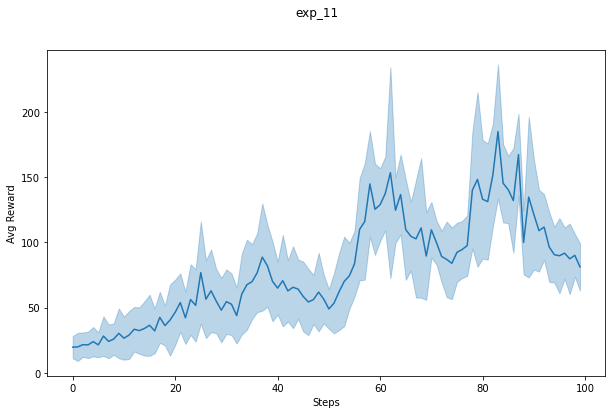

In [ ]:
# join de experimentos
exp_11=exp_11_1_CartPole
for i in [exp_11_2_CartPole,exp_11_3_CartPole]:
    exp_11=exp_11.join(i)

# Promedio de experimentos
exp_11_mean=pd.DataFrame()
exp_11_mean["avg_reward"]=exp_11[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_11_mean["std_reward"]=exp_11[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_11_mean.reset_index(inplace=True)
tr_steps_vec=exp_11_mean["steps"]
avg_reward_vec=exp_11_mean["avg_reward"]
std_reward_vec= exp_11_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_11")
plt.show()


# Exp 21

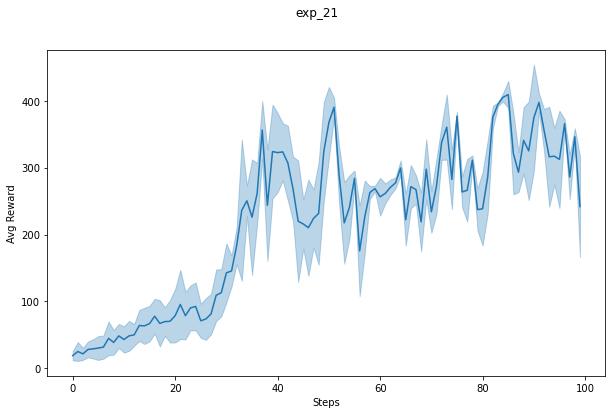

In [ ]:
# join de experimentos
exp_21=exp_21_1_CartPole
for i in [exp_21_2_CartPole,exp_21_3_CartPole]:
    exp_21=exp_21.join(i)

# Promedio de experimentos
exp_21_mean=pd.DataFrame()
exp_21_mean["avg_reward"]=exp_21[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_21_mean["std_reward"]=exp_21[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_21_mean.reset_index(inplace=True)
tr_steps_vec=exp_21_mean["steps"]
avg_reward_vec=exp_21_mean["avg_reward"]
std_reward_vec= exp_21_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_21")
plt.show()

# Exp 31

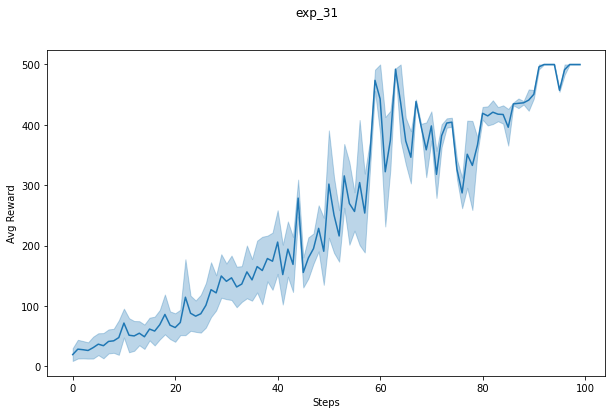

In [ ]:
# join de experimentos
exp_31=exp_31_1_CartPole
for i in [exp_31_2_CartPole,exp_31_3_CartPole]:
    exp_31=exp_31.join(i)

# Promedio de experimentos
exp_31_mean=pd.DataFrame()
exp_31_mean["avg_reward"]=exp_31[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_31_mean["std_reward"]=exp_31[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_31_mean.reset_index(inplace=True)
tr_steps_vec=exp_31_mean["steps"]
avg_reward_vec=exp_31_mean["avg_reward"]
std_reward_vec= exp_31_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_31")
plt.show()

### Pendulum

In [ ]:
exp_12_1_Pendulum=pd.read_csv("exp_12_1_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_12_2_Pendulum=pd.read_csv("exp_12_2_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_12_3_Pendulum=pd.read_csv("exp_12_3_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_22_1_Pendulum=pd.read_csv("exp_22_1_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_22_2_Pendulum=pd.read_csv("exp_22_2_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_22_3_Pendulum=pd.read_csv("exp_22_3_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})

exp_32_1_Pendulum=pd.read_csv("exp_32_1_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward1","std_reward":"std_reward1"})
exp_32_2_Pendulum=pd.read_csv("exp_32_2_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward2","std_reward":"std_reward2"})
exp_32_3_Pendulum=pd.read_csv("exp_32_3_Pendulum.csv").set_index("steps").rename(columns={"avg_reward":"avg_reward3","std_reward":"std_reward3"})


# Exp 12

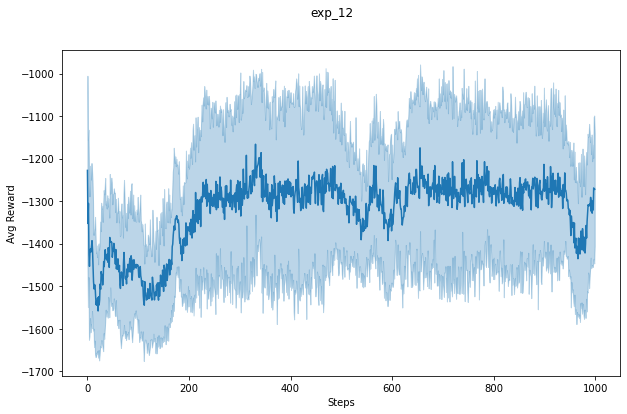

In [ ]:
# join de experimentos
exp_12=exp_12_1_Pendulum
for i in [exp_12_2_Pendulum,exp_12_3_Pendulum]:
    exp_12=exp_12.join(i)

# Promedio de experimentos
exp_12_mean=pd.DataFrame()
exp_12_mean["avg_reward"]=exp_12[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_12_mean["std_reward"]=exp_12[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_12_mean.reset_index(inplace=True)
tr_steps_vec=exp_12_mean["steps"]
avg_reward_vec=exp_12_mean["avg_reward"]
std_reward_vec= exp_12_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_12")
plt.show()

# Exp 22

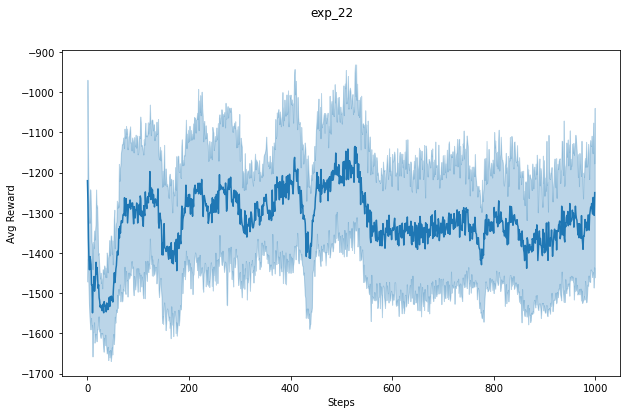

In [ ]:
# join de experimentos
exp_22=exp_22_1_Pendulum
for i in [exp_22_2_Pendulum,exp_22_3_Pendulum]:
    exp_22=exp_22.join(i)

# Promedio de experimentos
exp_22_mean=pd.DataFrame()
exp_22_mean["avg_reward"]=exp_22[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_22_mean["std_reward"]=exp_22[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_22_mean.reset_index(inplace=True)
tr_steps_vec=exp_22_mean["steps"]
avg_reward_vec=exp_22_mean["avg_reward"]
std_reward_vec= exp_22_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_22")
plt.show()

# Exp 32

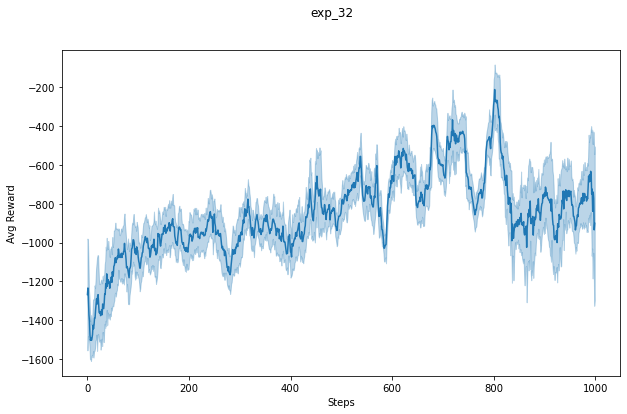

In [ ]:
# join de experimentos
exp_32=exp_32_1_Pendulum
for i in [exp_32_2_Pendulum,exp_32_3_Pendulum]:
    exp_32=exp_32.join(i)

# Promedio de experimentos
exp_32_mean=pd.DataFrame()
exp_32_mean["avg_reward"]=exp_32[["avg_reward1","avg_reward2","avg_reward3"]].mean(axis=1)
exp_32_mean["std_reward"]=exp_32[["std_reward1","std_reward2","std_reward3"]].mean(axis=1)
exp_32_mean.reset_index(inplace=True)
tr_steps_vec=exp_32_mean["steps"]
avg_reward_vec=exp_32_mean["avg_reward"]
std_reward_vec= exp_32_mean["std_reward"]

# Plot
_, (ax1) = plt.subplots(1, 1, figsize=(10,6))
ax1.plot(tr_steps_vec, avg_reward_vec, color='C0')
ax1.fill_between(tr_steps_vec, avg_reward_vec-std_reward_vec, avg_reward_vec+std_reward_vec, color='C0', alpha=0.3)
ax1.set_ylabel('Avg Reward')
ax1.set_xlabel('Steps')
plt.suptitle("exp_32")
plt.show()